In [ ]:
pip install kaggle

In [ ]:
import os
!mkdir ~/.kaggle.json

mkdir: cannot create directory ‘/root/.kaggle.json’: File exists


In [ ]:
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# Download the dataset
!kaggle datasets download -d bhavikardeshna/visual-question-answering-computer-vision-nlp

visual-question-answering-computer-vision-nlp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
import os

# Path to the downloaded zip file
zip_file_path = 'visual-question-answering-computer-vision-nlp.zip'  # Update with your file name

# Directory to extract the contents to
extracted_dir_path = 'visual-question-answering-computer-vision-nlp'  # Update with your desired directory name

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Files extracted successfully:", extracted_files)

Files extracted successfully: ['dataset']


In [ ]:
pip install datasets

In [ ]:
pip install typing

In [ ]:

import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Define a regex pattern to normalize the question &
# find the image ID for which the question is asked
import regex as re
import pandas as pd
from sklearn.model_selection import train_test_split
image_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

with open('visual-question-answering-computer-vision-nlp/dataset/all_qa_pairs.txt') as f:
    qa_data = [x.replace("\n", "") for x in f.readlines()]

df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})

for i in range(0, len(qa_data), 2):
    img_id = image_pattern.findall(qa_data[i])[0][3]
    question = qa_data[i].replace(image_pattern.findall(qa_data[i])[0][0], "")
    record = {
        "question": question,
        "answer": qa_data[i+1],
        "image_id": img_id,
    }
    df = df._append(record, ignore_index=True)

# Create a list of all possible answers, so that the answer generation part of the VQA task
# can be modelled as multiclass classification
answer_space = []
for ans in df.answer.to_list():
    answer_space = answer_space + [ans] if "," not in ans else answer_space + ans.replace(" ", "").split(",")

answer_space = list(set(answer_space))
answer_space.sort()
with open('visual-question-answering-computer-vision-nlp/dataset/answer_space.txt', 'w') as f:
    f.writelines("\n".join(answer_space))

# Since the actual dataset contains only ~54% of the data for training (very less),
# we produce our own splits for training & evaluation with 80% data being used for training
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv('visual-question-answering-computer-vision-nlp/dataset/data_train.csv', index=None)
test_df.to_csv('visual-question-answering-computer-vision-nlp/dataset/data_eval.csv', index=None)

In [ ]:

# Load the training & evaluation dataset present in CSV format
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join('visual-question-answering-computer-vision-nlp/dataset/data_train.csv'),
        "test": os.path.join('visual-question-answering-computer-vision-nlp/dataset/data_eval.csv',)
    }
)

# Load the space of all possible answers
with open('visual-question-answering-computer-vision-nlp/dataset/answer_space.txt',) as f:
    answer_space = f.read().splitlines()

# Since we model the VQA task as a multiclass classification problem,
# we need to create the labels from the actual answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            # Select the 1st answer if multiple answers are provided for single question
            answer_space.index(ans.replace(" ", "").split(",")[0])
            for ans in examples['answer']
        ]
    },
    batched=True
)

NameError: ignored

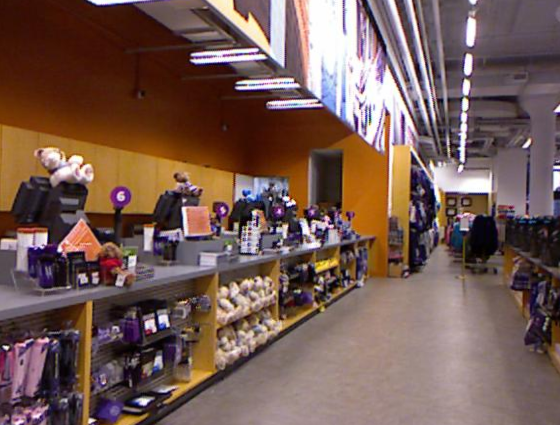

Question:	 what is in the shelves beneath the table
Answer:		 doll (Label: 174)


In [ ]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("visual-question-answering-computer-vision-nlp", "dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

showExample()

In [ ]:
# The dataclass decorator is used to automatically generate special methods to classes,
# including __init__, __str__ and __repr__. It helps reduce some boilerplate code.
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(self,  pretrained_text_name, pretrained_image_name, num_labels=len(answer_space), intermediate_dim=512, dropout=0.5):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

	# Pretrained transformers for text & image featurization
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

	# Fusion layer for cross-modal interaction
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

	# Fully-connected classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    # Initialize the correct text tokenizer and image feature extractor, and use them to create the collator
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)
    multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)

    # Initialize the multimodal model with the appropriate weights from pretrained models
    multimodal_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)

    return multimodal_collator, multimodal_model

In [ ]:
# Wrapper around the wup_measure(...) function to process batch inputs
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

# Function to compute all relevant performance metrics, to be passed into the trainer
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import Trainer, TrainingArguments


In [ ]:
import accelerate

In [114]:
multi_args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Since models are large, save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=False,
    fp16_full_eval=False,  # Set fp16_full_eval to True
)

ImportError: ignored

In [ ]:
pip install transformers[torch] -U


In [ ]:
pip install accelerate>=0.20.1 -U

In [ ]:
multi_args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Since models are large, save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

# Initialize the actual collator and multimodal model
collator, model = createMultimodalVQACollatorAndModel("bert-base-uncased", "google/vit-base-patch16-224-in21k")

# Initialize the trainer with the dataset, collator, model, hyperparameters and evaluation metrics
multi_trainer = Trainer(
	model,
	multi_args,
	train_dataset=dataset['train'],
	eval_dataset=dataset['test'],
	data_collator=collator,
	compute_metrics=compute_metrics
)

# Start the training loop
train_multi_metrics = multi_trainer.train()

# Run the model on the evaluation set to obtain final metrics
eval_multi_metrics = multi_trainer.evaluate()


ImportError: ignored

In [ ]:
pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.25.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
b